In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from sklearn.model_selection import train_test_split
# import keras_efficientnet_v2
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = '/content/drive/MyDrive/IP_dataset_minimized/Train_Alphabet'
test_dir = '/content/drive/MyDrive/IP_dataset_minimized/Test_Alphabet'

In [4]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)

    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [5]:
train_df.sample(5)

,filename,label
1608,K/f78163d4-7ffa-4a6f-8177-727671d4399d.rgb_000...,K
3652,Y/Copy of fd2dcc22-19cd-4410-8a39-1b139856a326...,Y
1116,F/ebc8b786-f8f5-4d80-944d-cefb6fe14aba.rgb_000...,F
4183,U/eb920ee9-5844-40bf-895f-ef2253595949.rgb_000...,U
1056,E/faf8a707-b607-4fa5-889e-d6996dc91e6c.rgb_000...,E


In [6]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(3435,)
(859,)


In [7]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [8]:
train['label'].value_counts()

label
U        129
V        128
Blank    128
O        128
D        128
S        127
F        127
B        127
E        127
M        127
I        127
G        127
J        127
L        127
K        127
W        127
N        127
T        127
X        127
Q        127
Z        127
R        127
Y        127
P        127
H        127
A        127
C        127
Name: count, dtype: int64

In [9]:
valid['label'].value_counts()

label
K        32
Z        32
C        32
H        32
N        32
I        32
J        32
T        32
B        32
Y        32
U        32
G        32
L        32
Blank    32
E        32
S        32
X        32
F        32
A        32
W        32
R        32
P        32
D        31
M        31
Q        31
O        31
V        31
Name: count, dtype: int64

In [10]:
test['label'].value_counts()

label
Z        39
H        39
Blank    39
A        39
B        39
D        39
J        39
G        39
L        39
M        39
E        39
I        39
K        39
F        39
Y        39
N        39
T        39
W        39
V        39
S        39
R        39
Q        39
P        39
U        39
O        39
X        39
C        39
Name: count, dtype: int64

In [11]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 3435 validated image filenames belonging to 27 classes.
Found 859 validated image filenames belonging to 27 classes.
Found 1053 validated image filenames.


In [12]:
tf.keras.backend.clear_session()
num_classes = 27

backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='inputs')
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
# x = Dense(100, activation='relu')(x)
outputs = Dense(27, activation='softmax')(x)

model_efficientnet = tf.keras.Model(inputs=inputs, outputs=outputs, name='efficientnet_model')
model_efficientnet.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 27)                34587     
                                                 

In [13]:
tf.keras.backend.clear_session()
num_classes = 27
model_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SIZE + (3,))
# Create our own model
# inputs = Input(shape=IMAGE_SIZE + (3,), name='inputs')
# x = feature_extractor_layer(inputs, training=False)
# x = Dropout(0.2)(x)
# outputs = Dense(27, activation='softmax')(x)

# model_efficientnet = tf.keras.Model(inputs=inputs, outputs=outputs, name='efficientnet_model')

model_efficientnet = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    Dropout(0.2),
    Dense(num_classes, activation='softmax') # create our own output layer
])

model_efficientnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 27)                34587     
                                                                 
Total params: 5953899 (22.71 MB)
Trainable params: 34587 (135.11 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [14]:
model_efficientnet.compile(optimizer=keras.optimizers.Adam(),
                           loss='sparse_categorical_crossentropy',
                           metrics=["accuracy"])

In [15]:
cb = [
#     callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('model_efficientnet.hdf5', save_best_only=True, monitor='val_loss')
]

history_efficientnet = model_efficientnet.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 20,
    batch_size = 128,
    verbose = 1,
    callbacks = cb
)

Epoch 1/20
108/108 [==============================] - 1200s 11s/step - loss: 1.9845 - accuracy: 0.5467 - val_loss: 1.1502 - val_accuracy: 0.8184
Epoch 2/20
108/108 [==============================] - 396s 4s/step - loss: 0.8631 - accuracy: 0.8582 - val_loss: 0.6823 - val_accuracy: 0.8836
Epoch 3/20
108/108 [==============================] - 387s 4s/step - loss: 0.5633 - accuracy: 0.9112 - val_loss: 0.5012 - val_accuracy: 0.9045
Epoch 4/20
108/108 [==============================] - 386s 4s/step - loss: 0.4215 - accuracy: 0.9339 - val_loss: 0.3790 - val_accuracy: 0.9499
Epoch 5/20
108/108 [==============================] - 389s 4s/step - loss: 0.3322 - accuracy: 0.9543 - val_loss: 0.3270 - val_accuracy: 0.9534
Epoch 6/20
108/108 [==============================] - 397s 4s/step - loss: 0.2738 - accuracy: 0.9642 - val_loss: 0.2946 - val_accuracy: 0.9511
Epoch 7/20
108/108 [==============================] - 387s 4s/step - loss: 0.2440 - accuracy: 0.9648 - val_loss: 0.2602 - val_accuracy: 0.95

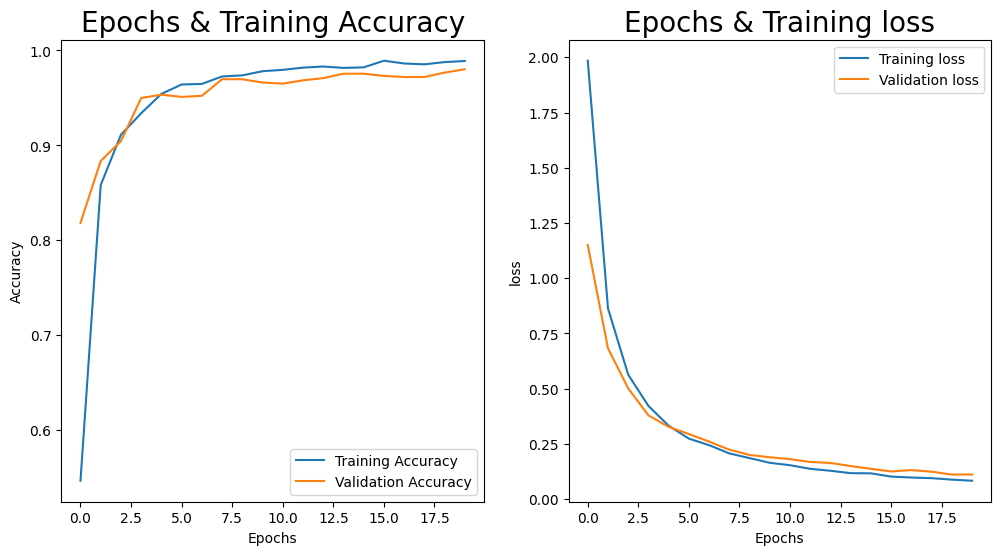

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_efficientnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_efficientnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_efficientnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_efficientnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [17]:
model_loaded = model_efficientnet

In [18]:
test_generator.reset()
pred = model_loaded.predict(test_generator, verbose=1)

1053/1053 [==============================] - 277s 263ms/step


In [19]:
pred = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(accuracy_score(test['label'], pred))
print(classification_report(test['label'], pred))

0.9753086419753086
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        39
           B       1.00      1.00      1.00        39
       Blank       1.00      1.00      1.00        39
           C       1.00      0.90      0.95        39
           D       0.93      1.00      0.96        39
           E       0.97      1.00      0.99        39
           F       1.00      1.00      1.00        39
           G       0.97      0.97      0.97        39
           H       1.00      0.97      0.99        39
           I       1.00      1.00      1.00        39
           J       0.93      1.00      0.96        39
           K       0.97      1.00      0.99        39
           L       1.00      1.00      1.00        39
           M       0.88      0.95      0.91        39
           N       1.00      0.79      0.89        39
           O       0.93      0.95      0.94        39
           P       0.97      1.00      0.99        39
        